In [ ]:
import os
import csv
import re
import gc
import glob
import pickle
import warnings
import logging
import datetime
import zipfile
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime
from tqdm import tqdm
import humanize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import scipy.stats as ss
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import ukbiobank.utils.utils
from ukbiobank.utils import fieldNamesToIds
from ukbiobank.utils import loadCsv
from ukbiobank.utils import addFields
from ukbiobank.utils.utils import getFieldnames
from ukbiobank.utils.utils import fieldIdsToNames

# Resting State

1. Amplitudes
2. Nodes timeseries => 
- full correlation matrix
- partial correlation matrix
- tangent transformation

21 out of 25 and 55 out of 100 'good' components

# 1. rsMRI connectomes

### Extract timeseries tables

Index calculation (for cluster):

- task_id % len(atlas_list) → selects atlas
- task_id // len(atlas_list) → selects file index

This setup will parallelize across all atlas-file combinations. For the case with 4 atlases and max 3 files per atlas, use --array=0-11 (since 4×3=12 combinations).

In [ ]:
# Rename folders
def rename_files(root_dir, folder_patterns):
    import glob
    """
    Renames files across specified folders with pattern-specific rules.
    
    Args:
        root_dir (str): Parent directory containing subfolders.
        folder_patterns (dict): Dictionary of {folder_pattern: renaming_rules}
    """
    # Get all subdirectories matching our patterns
    subdirs = [d for d in glob.glob(os.path.join(root_dir, '*'))  # Changed glob() to glob.glob()
              if os.path.isdir(d) and any(p in d for p in folder_patterns.keys())]
    
    for folder in subdirs:
        folder_name = os.path.basename(folder)
        print(f"\nProcessing folder: {folder_name}")
        
        # Find which pattern matches this folder
        pattern = next(p for p in folder_patterns if p in folder_name)
        rules = folder_patterns[pattern]
        
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isdir(filepath):
                continue
                
            new_name = filename
            
            # Apply pattern-specific renaming rules
            for old_str in rules.get('remove', []):
                new_name = new_name.replace(old_str, '')
                
            for old, new in rules.get('replace', {}).items():
                new_name = new_name.replace(old, new)
            
            # Clean up residual double underscores
            new_name = new_name.replace('__', '_').replace('___', '_')
            
            if new_name != filename:
                new_path = os.path.join(folder, new_name)
                if not os.path.exists(new_path):
                    os.rename(filepath, new_path)
                    print(f"Renamed: {filename} → {new_name}")
                else:
                    print(f"Conflict: {new_name} already exists!")

# Configuration for each folder pattern
FOLDER_RULES = {
    '31014_aparc_a2009s': {
        'remove': [
            '31014_aparc_a2009s_fMRI_',
        ],
        'replace': {
            '__': '_',
        }
    },
    '31015_aparc': {
        'remove': [
            '31015_aparc_fMRI_',
        ],
        'replace': {
            '__': '_'
        }
    },
    '31016_Glasser': {
        'remove': [
            '31016_Glasser_fMRI_',
        ],
        'replace': {
            '__': '_'
        }
    },
    '31018_Schaefer7ns': {
        'remove': [
            '31018_Schaefer7ns_fMRI_',
        ],
        'replace': {
            '__': '_'
        }
    }
}

root_directory = "/UK_BB/brainbody/brain/data/rsMRI/connectomes"
rename_files(
    root_dir=root_directory,
    folder_patterns=FOLDER_RULES
)

Upload timeseries files

In [ ]:
# Configuration and helpers for processing timeseries data
import os
import sys
import gc
import pickle
import pandas as pd
from tqdm import tqdm

BASE_PATH = "/UKBiobank/Connectomes/rsMRI"
OUTPUT_BASE = "/UKBiobank/Connectomes/rsMRI/processed"

# Atlas configurations
ATLAS_CONFIG = {
    '31015_aparc': '43419',
    '31016_Glasser': '43419',
    '31018_Schaefer7ns': '43419',
    '31019_Tian_Subcortex': '43350'
}

# Timeseries files
TIMESERIES_FILES = {
   '31015_aparc': ['fMRI.aparc.csv.gz'],
   '31016_Glasser': ['fMRI.Glasser.csv.gz'],
   '31018_Schaefer7ns': [
       'fMRI.Schaefer7n200p.csv.gz',
       'fMRI.Schaefer7n500p.csv.gz',
       'fMRI.Schaefer7n1000p.csv.gz'
   ],
   '31019_Tian_Subcortex': [
       'fMRI.Tian_Subcortex_S1_3T.csv.gz',
       'fMRI.Tian_Subcortex_S4_3T.csv.gz'
   ]
}

# Common folder chunks
FOLDER_CHUNKS = ["10000", "20000", "30000", "40000"]

def generate_folder_paths(atlas_name, last_chunk):
    """Generate all folder paths for a given atlas"""
    return [os.path.join(BASE_PATH, atlas_name, chunk, "unzipped") 
            for chunk in FOLDER_CHUNKS + [last_chunk]]

def process_atlas_file(atlas_name, last_chunk, timeseries_file):
    """Process specific file for parallelization"""
    folder_paths = generate_folder_paths(atlas_name, last_chunk)
    
    print(f"\nProcessing {atlas_name} - {timeseries_file}")
    print("=" * 50)
    
    # Initialize storage
    missing_file_count = 0
    skipped_folders = []
    full_timeseries_dict = {}
    instance2_timeseries_dict = {}
    
    for folder_path in tqdm(folder_paths, desc="Processing chunks"):
        if not os.path.exists(folder_path):
            print(f"Warning: Folder not found - {folder_path}")
            skipped_folders.append(folder_path)
            continue
            
        subject_folders = sorted(os.listdir(folder_path))
        for subject_folder in tqdm(subject_folders, desc=f"Processing {os.path.basename(folder_path)}", leave=False):
            subfolder_path = os.path.join(folder_path, subject_folder)
            timeseries_path = os.path.join(subfolder_path, timeseries_file)
            
            if not os.path.exists(timeseries_path):
                missing_file_count += 1
                skipped_folders.append(subfolder_path)
                continue
            
            try:
                timeseries = pd.read_csv(timeseries_path, compression='gzip')
                
                # Store full dataset
                full_timeseries_dict[subject_folder] = timeseries
                
                # Check for instance 2
                if '_2_' in subject_folder:
                    clean_id = subject_folder.replace(f'_{atlas_name.split("_")[0]}_2_0', '')
                    instance2_timeseries_dict[clean_id] = timeseries
                    
            except Exception as e:
                print(f"Error processing {timeseries_path}: {str(e)}")
                continue
    
    # Save outputs
    safe_filename = timeseries_file.replace('.', '_').replace('csv_gz', '')
    atlas_output_dir = os.path.join(OUTPUT_BASE, atlas_name)
    os.makedirs(atlas_output_dir, exist_ok=True)
    
    # Save full dataset
    pd.DataFrame(list(full_timeseries_dict.keys()), columns=['ID']).to_csv(
        os.path.join(atlas_output_dir, f'id_{atlas_name}_{safe_filename}_full.csv'), 
        index=False
    )
    with open(os.path.join(atlas_output_dir, f'timeseries_{atlas_name}_{safe_filename}_full_dict.pkl'), 'wb') as f:
        pickle.dump(full_timeseries_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save instance 2 dataset if found
    if instance2_timeseries_dict:
        pd.DataFrame(list(instance2_timeseries_dict.keys()), columns=['ID']).to_csv(
            os.path.join(atlas_output_dir, f'id_{atlas_name}_{safe_filename}_i2.csv'), 
            index=False
        )
        with open(os.path.join(atlas_output_dir, f'timeseries_{atlas_name}_{safe_filename}_i2_dict.pkl'), 'wb') as f:
            pickle.dump(instance2_timeseries_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Print summary
    print(f"\nFile {timeseries_file} processing complete!")
    print(f"Number of folders without the file: {missing_file_count}")
    if skipped_folders:
        print("\nSkipped folders (sample):")
        for folder in skipped_folders[:5]:
            print(f"- {folder}")
        if len(skipped_folders) > 5:
            print(f"- ... and {len(skipped_folders)-5} more")
    
    return True

# ================================================================
# Execute on PC
def main():
    for atlas_name, last_chunk in ATLAS_CONFIG.items():
        process_atlas(atlas_name, last_chunk)
        gc.collect()

if __name__ == "__main__":
    import os
    import gc
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    import pickle
    
    main()
    print("\nAll atlases processed successfully!")
# ================================================================
# ================================================================
# Execute on cluster
def main():
    # Convert config to list for indexing
    atlas_items = list(ATLAS_CONFIG.items())
    
    # SLURM task handling
    if len(sys.argv) > 1:
        task_id = int(sys.argv[1])
        atlas_idx = task_id % len(atlas_items)
        file_idx = task_id // len(atlas_items)
        
        atlas_name, last_chunk = atlas_items[atlas_idx]
        atlas_files = TIMESERIES_FILES.get(atlas_name, [])
        
        if file_idx < len(atlas_files):
            process_atlas_file(atlas_name, last_chunk, atlas_files[file_idx])
        else:
            print(f"No file at index {file_idx} for {atlas_name}")
    else:
        # Local execution
        for atlas_name, last_chunk in atlas_items:
            for timeseries_file in TIMESERIES_FILES.get(atlas_name, []):
                process_atlas_file(atlas_name, last_chunk, timeseries_file)
            gc.collect()

if __name__ == "__main__":
    main()
    print("\nProcessing complete!")

### Combine cortical and subcortical atlases

- 31020 aparc.a2009s Tian S1
- 31021 aparc Tian S1
- 31022 Glasser Tian S1
- 3102 Glasser Tian S4
- 31024 Schaefer7n1000p Tian S4
- 31025 Schaefer7n200p Tian S1
- 31026 Schaefer7n500p Tian S4

In [ ]:
# Set up paths
connectomes_dir = '/UK_BB/brainbody/brain/data/rsMRI/connectomes'
connectomes_dir_aoraki = '/UK_BB/brainbody/brain/data/rsMRI/connectomes'

In [ ]:
# Configuration and helpers for merging cortical and subcortical timeseries
import os
import sys
import pickle
import pandas as pd
from tqdm import tqdm
import gc

connectomes_dir = '/UK_BB/brainbody/brain/data/rsMRI/connectomes'

# Define all desired combinations as a LIST (for SLURM array indexing)
combinations = [
    {  # Index 0
        'name': 'aparc_Tian_S1',
        'cort_path': os.path.join(connectomes_dir, '31015_aparc/timeseries_aparc_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S1_i2_dict.pkl'),
        'cort_name': 'aparc',
        'subcort_name': 'Tian_S1'
    },
    {  # Index 1
        'name': 'Glasser_Tian_S1',
        'cort_path': os.path.join(connectomes_dir, '31016_Glasser/timeseries_Glasser_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S1_i2_dict.pkl'),
        'cort_name': 'Glasser',
        'subcort_name': 'Tian_S1'
    },
    {  # Index 2
        'name': 'Glasser_Tian_S4',
        'cort_path': os.path.join(connectomes_dir, '31016_Glasser/timeseries_Glasser_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S4_i2_dict.pkl'),
        'cort_name': 'Glasser',
        'subcort_name': 'Tian_S4'
    },
    {  # Index 3
        'name': 'Schaefer7n1000p_Tian_S4',
        'cort_path': os.path.join(connectomes_dir, '31018_Schaefer7ns/timeseries_Schaefer7n1000p_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S4_i2_dict.pkl'),
        'cort_name': 'Schaefer7n1000p',
        'subcort_name': 'Tian_S4'
    },
    {  # Index 4
        'name': 'Schaefer7n200p_Tian_S1',
        'cort_path': os.path.join(connectomes_dir, '31018_Schaefer7ns/timeseries_Schaefer7n200p_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S1_i2_dict.pkl'),
        'cort_name': 'Schaefer7n200p',
        'subcort_name': 'Tian_S1'
    },
    {  # Index 5
        'name': 'Schaefer7n500p_Tian_S4',
        'cort_path': os.path.join(connectomes_dir, '31018_Schaefer7ns/timeseries_Schaefer7n500p_i2_dict.pkl'),
        'subcort_path': os.path.join(connectomes_dir, '31019_Tian_Subcortex/timeseries_Tian_Subcortex_S4_i2_dict.pkl'),
        'cort_name': 'Schaefer7n500p',
        'subcort_name': 'Tian_S4'
    }
]

def load_dict(path):
    """Load dictionary, unwrapping if numpy array"""
    with open(path, 'rb') as f:
        data = pickle.load(f)
        return data.item() if hasattr(data, 'item') else data

def merge_cortical_subcortical(cort_path, subcort_path, cort_name, subcort_name):
    """Optimized version of your function"""
    # Load data
    cort = load_dict(cort_path)
    subcort = load_dict(subcort_path)
    
    # Merge with progress tracking
    merged = {}
    for key, value in tqdm(cort.items(), desc=f"Merging {cort_name} + {subcort_name}"):
        if key in subcort:
            try:
                merged[key] = pd.concat([
                    pd.DataFrame(value),
                    pd.DataFrame(subcort[key])
                ], ignore_index=True)
            except Exception as e:
                print(f"Skipped {key}: {str(e)}")
    
    # Save results
    os.makedirs(os.path.join(connectomes_dir, 'combined'), exist_ok=True)
    output_path = os.path.join(connectomes_dir, f'combined/{cort_name}_{subcort_name}.pkl')
    with open(output_path, 'wb') as f:
        pickle.dump(merged, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Cleanup
    del cort, subcort
    gc.collect()
    
    print(f"✅ Successfully merged {len(merged)} subjects for {cort_name} + {subcort_name}")
    return merged

# Run the script
def main():
    # SLURM task handling
    if len(sys.argv) > 1:
        task_id = int(sys.argv[1])
        if task_id < len(combinations):
            combo = combinations[task_id]  # Now works because combinations is a list
            print(f"\nProcessing combination {task_id}: {combo['name']}")
            merge_cortical_subcortical(
                cort_path=combo['cort_path'],
                subcort_path=combo['subcort_path'],
                cort_name=combo['cort_name'],
                subcort_name=combo['subcort_name']
            )
        else:
            print(f"Task ID {task_id} exceeds number of combinations ({len(combinations)})")
    else:
        # Local execution - process all combinations sequentially
        for combo in combinations:
            print(f"\nProcessing combination: {combo['name']}")
            merge_cortical_subcortical(
                cort_path=combo['cort_path'],
                subcort_path=combo['subcort_path'],
                cort_name=combo['cort_name'],
                subcort_name=combo['subcort_name']
            )
            gc.collect()

if __name__ == "__main__":
    main()
    print("\nProcessing complete!")

### Transpose and get full and partial correlation matrices

In [ ]:
# Configuration and helpers for computing connectivity matrices
import pandas as pd
import pickle
import gc
import numpy as np
import nilearn
from nilearn.connectome import ConnectivityMeasure
import os
import sys
import warnings
warnings.filterwarnings('ignore')

connectomes_dir = '/UK_BB/brainbody/brain/data/rsMRI/connectomes'
os.makedirs(os.path.join(connectomes_dir, 'nilearn'), exist_ok=True)

def process_modality(modality):
    print(f'Processing {modality}', flush=True)
    
    # Load data
    input_path = os.path.join(connectomes_dir, 'combined', f'{modality}.pkl')
    with open(input_path, 'rb') as f:
        atlas = pickle.load(f)
    
    # Prepare data
    print('Extracting values and transposing', flush=True)
    atlas_array_transposed = [df.iloc[:, 1:].values.T for df in atlas.values()]
    keys = list(atlas.keys())
    
    # Save intermediate files
    with open(os.path.join(connectomes_dir, f'nilearn/{modality}_array_transposed.pkl'), 'wb') as f:
        pickle.dump(atlas_array_transposed, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    pd.DataFrame(keys, columns=['eid']).to_csv(
        os.path.join(connectomes_dir, f'nilearn/{modality}_id.csv'), 
        index=False
    )
    
    # Initialize connectivity measures
    print('Initializing connectivity measures', flush=True)
    correlation_measure = ConnectivityMeasure(
        kind='correlation',
        standardize="zscore_sample",
        vectorize=True,
        discard_diagonal=True
    )
    
    partial_correlation_measure = ConnectivityMeasure(
        kind='partial correlation',
        standardize="zscore_sample",
        vectorize=True,
        discard_diagonal=True
    )
    
    # Initialize result containers
    full_correlation = []
    partial_correlation = []
    nan_indices = []
    valid_ids = []
    
    # Process each subject
    for i, (array, key) in enumerate(zip(atlas_array_transposed, keys)):
        if np.isnan(array).any():
            print(f"Skipping {key} due to NaN values", flush=True)
            nan_indices.append(i)
            continue
            
        try:
            # Compute both correlation and partial correlation
            corr_matrix = correlation_measure.fit_transform([array])
            partial_matrix = partial_correlation_measure.fit_transform([array])
            
            # Apply Fisher Z-transform
            full_correlation.append(np.arctanh(corr_matrix))
            partial_correlation.append(np.arctanh(partial_matrix))
            valid_ids.append(str(key))
            print(f"Processed {key} successfully", flush=True)
        except Exception as e:
            print(f"Error processing {key}: {str(e)}", flush=True)
            nan_indices.append(i)
    
    # Save results
    if full_correlation:
        # Convert to DataFrames with eid
        full_corr_df = pd.DataFrame(
            np.squeeze(full_correlation),
            index=valid_ids
        )
        partial_corr_df = pd.DataFrame(
            np.squeeze(partial_correlation),
            index=valid_ids
        )
        
        # Save as CSV
        full_corr_df.to_csv(
            os.path.join(connectomes_dir, f'nilearn/full_correlation_{modality}.csv'),
            index_label='eid'
        )
        partial_corr_df.to_csv(
            os.path.join(connectomes_dir, f'nilearn/partial_correlation_{modality}.csv'),
            index_label='eid'
        )
        
        # Save as pickle
        with open(os.path.join(connectomes_dir, f'nilearn/full_correlation_{modality}.pkl'), 'wb') as f:
            pickle.dump(full_corr_df, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(connectomes_dir, f'nilearn/partial_correlation_{modality}.pkl'), 'wb') as f:
            pickle.dump(partial_corr_df, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save NaN indices
    if nan_indices:
        nan_ids = [str(keys[i]) for i in nan_indices]
        pd.DataFrame(nan_ids, columns=['eid']).to_csv(
            os.path.join(connectomes_dir, f'nilearn/{modality}_nan_id.csv'),
            index=False
        )
    
    print(f"Completed {modality}. Skipped {len(nan_indices)} participants.", flush=True)
    gc.collect()

# Run the script
if __name__ == "__main__":
    modalities = [
        'aparc_a2009s_Tian_S1',
        'aparc_Tian_S1',
        'Glasser_Tian_S1',
        'Glasser_Tian_S4',
        'Schaefer7n200p_Tian_S1',
        #'Schaefer7n500p_Tian_S4',
        'Schaefer7n1000p_Tian_S4'
    ]
    
    # SLURM array support
    if len(sys.argv) > 1:
        task_id = int(sys.argv[1])
        modality = modalities[task_id]
        process_modality(modality)
    else:
        for modality in modalities:
            process_modality(modality)
            gc.collect()

# 2. rsMRI amplitudes

In [ ]:
# Upload UK Bioabank csv
csv_path = '/UK_BB/ukbbdata/ukb.csv'
ukb = ukbiobank.ukbio(ukb_csv=csv_path)

In [ ]:
# Create directories
base_path = f'/UK_BB/brainbody'
brain_path = os.path.join(base_path, 'brain')
data_path = os.path.join(brain_path, 'data')
os.makedirs(base_path, exist_ok=True)
os.makedirs(brain_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(shap_path, exist_ok=True)

## 21 IC

In [ ]:
# Collect all file names
import glob 
input_path = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-amplitudes-21-25754/"
output_path = os.path.join(data_path, 'rsMRI/amplitudes')
os.makedirs(output_path, exist_ok=True)

# Get all .txt files and extract filenames in one step
file_names = [os.path.basename(f) for f in glob.glob(os.path.join(input_path, "*.txt"))]
file_data = pd.DataFrame({'filenames': file_names})

# Sort filenames
file_data_sorted = file_data.sort_values('filenames').reset_index(drop=True)

# Extract eid
file_data['ID'] = file_data['filenames'].str.split('_').str[0]
file_data_sorted['ID'] = file_data_sorted['filenames'].str.split('_').str[0]

# Save all outputs with descriptive names
output_files = {
    'rfMRI_amplitudes_21ic_file_names_full.csv': file_data[['filenames']],
    'rfMRI_amplitudes_21ic_file_names_sorted.csv': file_data_sorted[['filenames']],
    'rfMRI_amplitudes_21ic_eid_full.csv': file_data[['ID']],
    'rfMRI_amplitudes_21ic_eid_sorted.csv': file_data_sorted[['ID']]
}

for filename, df in output_files.items():
    df.to_csv(os.path.join(output_path, filename), index=False)

print("Preparation complete. Saved files:")
print("\n".join([f"- {os.path.join(output_path, f)}" for f in output_files.keys()]))

In [ ]:
# Assemble amplitude files into one data frame
input_path = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-amplitudes-21-25754/"
output_path = os.path.join(data_path, 'rsMRI/amplitudes')
batch_size = 5000  # Adjust based on your memory capacity
os.makedirs(output_path, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(output_path, 'amplitude_processing.log')),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def setup_logging():
    """Set up logging configuration"""
    log_file = os.path.join(output_path, f"amplitude_processing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

# Load the sorted filenames
try:
    file_data_sorted = pd.read_csv(os.path.join(output_path, "rfMRI_amplitudes_21ic_file_names_sorted.csv")) 
    file_names = file_data_sorted["filenames"]
    logger.info(f"Successfully loaded {len(file_names)} files to process")
except Exception as e:
    logger.error(f"Failed to load file list: {str(e)}")
    raise

def process_amplitude_batch(file_list, batch_id, pbar=None):
    """Process a batch of amplitude files and save results."""
    batch_data = []
    processed_count = 0
    error_count = 0
    
    for file_name in file_list:
        file_path = os.path.join(input_path, file_name)
        try:
            # Read the amplitude file
            df = pd.read_csv(file_path, sep="\\s+", header=None)
            
            # Format columns and index
            df.columns = [f'Component_{i+1}_Amplitude' for i in range(df.shape[1])]
            df.index = [file_name.split(".")[0]]  # Use filename without extension as index
            
            batch_data.append(df)
            processed_count += 1
            if pbar:
                pbar.update(1)
                
        except Exception as e:
            error_count += 1
            logger.warning(f"Error processing {file_name}: {str(e)}")
            continue
    
    if batch_data:
        # Combine and save the batch
        batch_df = pd.concat(batch_data, axis=0)
        output_file = os.path.join(output_path, f"rfMRI_amplitudes_batch_{batch_id}.csv")
        batch_df.to_csv(output_file, index=False)
        logger.info(f"Saved batch {batch_id} with {processed_count} files ({len(batch_df)} rows). Errors: {error_count}")
    else:
        logger.warning(f"Batch {batch_id} had no valid files to process")
    
    return processed_count, error_count

# Process in batches
total_files = len(file_names)
total_processed = 0
total_errors = 0

logger.info(f"Starting processing of {total_files} files in batches of {batch_size}")
start_time = datetime.now()

with tqdm(total=total_files, desc="Processing files", unit="file") as pbar:
    for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
        batch_id = f"{i+1}-{min(i+batch_size, total_files)}"
        batch_files = file_names[i:i+batch_size]
        
        logger.info(f"Processing batch {batch_num}: files {i+1} to {min(i+batch_size, total_files)}")
        processed, errors = process_amplitude_batch(batch_files, batch_id, pbar)
        
        total_processed += processed
        total_errors += errors

duration = datetime.now() - start_time
logger.info(f"\nProcessing completed in {duration}")
logger.info(f"Total files processed successfully: {total_processed}/{total_files}")
logger.info(f"Total files with errors: {total_errors}")
logger.info(f"Batch files saved to: {output_path}")

In [ ]:
# Combine batches into one data frame
input_dir = "/UK_BB/brainbody/brain/data/rsMRI/amplitudes/"
output_dir = os.path.join(data_path, 'rsMRI/amplitudes')
os.makedirs(output_dir, exist_ok=True)
combined_filename = "rsmri_amplitudes_21.csv"

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(output_dir, f"combine_batches_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def combine_batches_with_ids():
    """Combine batches while adding full IDs from original filenames"""
    try:
        # Load the original sorted filenames
        filename_df = pd.read_csv(os.path.join(input_dir, "rfMRI_amplitudes_file_names_sorted.csv"))
        all_filenames = filename_df['filenames'].tolist()
        
        # Find all batch files in order
        batch_files = sorted([
            os.path.join(input_dir, f) 
            for f in os.listdir(input_dir) 
            if f.startswith('rfMRI_amplitudes_batch_') and f.endswith('.csv')
        ], key=lambda x: int(x.split('_')[-1].split('.')[0].split('-')[0]))
        
        if not batch_files:
            raise FileNotFoundError("No batch files found")
            
        logger.info(f"Found {len(batch_files)} batch files to combine")
        
        # Process each batch with proper ID assignment
        combined_dfs = []
        current_file_index = 0
        
        for batch_file in tqdm(batch_files, desc="Processing batches"):
            try:
                # Read the batch file
                df = pd.read_csv(batch_file)
                batch_size = len(df)
                
                # Get the corresponding filenames for this batch
                batch_filenames = all_filenames[current_file_index:current_file_index + batch_size]
                
                # Extract full IDs (remove .txt extension)
                full_ids = [f.split('.')[0] for f in batch_filenames]
                
                # Add ID column
                df['eid'] = full_ids
                
                # Reorder columns to have eid first
                cols = ['eid'] + [col for col in df.columns if col != 'eid']
                df = df[cols]
                
                combined_dfs.append(df)
                current_file_index += batch_size
                logger.info(f"Processed {batch_file} with {batch_size} rows")
                
            except Exception as e:
                logger.error(f"Error processing {batch_file}: {str(e)}")
                continue
        
        # Combine all dataframes
        final_df = pd.concat(combined_dfs, ignore_index=True)
        logger.info(f"Combined dataframe has {len(final_df)} rows with IDs")
        
        # Save final output
        output_path = os.path.join(output_dir, combined_filename)
        final_df.to_csv(output_path, index=False)
        logger.info(f"Saved final output to {output_path}")
        
        # Verify
        logger.info(f"Sample IDs: {final_df['eid'].head().tolist()}")
        
        return final_df
        
    except Exception as e:
        logger.error(f"Error in batch combination: {str(e)}")
        raise

if __name__ == "__main__":
    logger.info("Starting batch combination with ID assignment")
    combine_batches_with_ids()
    logger.info("Process completed successfully")

In [ ]:
# Filter Instance 2
amplitudes_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/amplitudes/rsmri_amplitudes_21.csv'))
amplitudes_21_i2 = amplitudes_21[~amplitudes_21["eid"].str.endswith('_3_0')].copy()
amplitudes_21_i2['eid'] = amplitudes_21_i2['eid'].str.split("_").str[0].astype(int)
# Save
amplitudes_21_i2.to_csv("/UK_BB/brainbody/brain/data/rsMRI/amplitudes/rsmri_amplitudes_21_i2.csv", index=False)
amplitudes_21_i2.to_csv("/UK_BB/brainbody/brain/data/rsMRI/amplitudes/amplitudes_21.csv", index=False)
print(f"Filtered data saved. Shape: {amplitudes_21_i2.shape}")

Filtered data saved. Shape: (44480, 22)


## 55 IC

In [ ]:
# Collect all file names
import glob 
input_path = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-amplitudes-55-25755/"
output_path = os.path.join(data_path, 'rsMRI/amplitudes')
os.makedirs(output_path, exist_ok=True)

# Get all .txt files and extract filenames in one step
file_names = [os.path.basename(f) for f in glob.glob(os.path.join(input_path, "*.txt"))]
file_data = pd.DataFrame({'filenames': file_names})

# Sort filenames
file_data_sorted = file_data.sort_values('filenames').reset_index(drop=True)

# Extract eid
file_data['ID'] = file_data['filenames'].str.split('_').str[0]
file_data_sorted['ID'] = file_data_sorted['filenames'].str.split('_').str[0]

# Save all outputs with descriptive names
output_files = {
    'rfMRI_amplitudes_55ic_file_names_full.csv': file_data[['filenames']],
    'rfMRI_amplitudes_55ic_file_names_sorted.csv': file_data_sorted[['filenames']],
    'rfMRI_amplitudes_55ic_eid_full.csv': file_data[['ID']],
    'rfMRI_amplitudes_55ic_eid_sorted.csv': file_data_sorted[['ID']]
}

for filename, df in output_files.items():
    df.to_csv(os.path.join(output_path, filename), index=False)

print("Preparation complete. Saved files:")
print("\n".join([f"- {os.path.join(output_path, f)}" for f in output_files.keys()]))

In [ ]:
# Assemble amplitude files into one data frame
input_path = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-amplitudes-55-25755/"
output_path = os.path.join(data_path, "rsMRI/amplitudes")
batch_size = 5000  # Adjust based on your memory capacity
os.makedirs(output_path, exist_ok=True)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(output_path, 'amplitude_processing.log')),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def setup_logging():
    """Set up logging configuration"""
    log_file = os.path.join(output_path, f"amplitude_processing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()

# Load the sorted filenames
try:
    file_data_sorted = pd.read_csv(os.path.join(output_path, "rfMRI_amplitudes_55ic_file_names_sorted.csv"))
    file_names = file_data_sorted["filenames"]
    logger.info(f"Successfully loaded {len(file_names)} files to process")
except Exception as e:
    logger.error(f"Failed to load file list: {str(e)}")
    raise

def process_amplitude_batch(file_list, batch_id, pbar=None):
    """Process a batch of amplitude files and save results."""
    batch_data = []
    processed_count = 0
    error_count = 0
    
    for file_name in file_list:
        file_path = os.path.join(input_path, file_name)
        try:
            # Read the amplitude file
            df = pd.read_csv(file_path, sep="\\s+", header=None)
            
            # Format columns and index
            df.columns = [f'Component_{i+1}_Amplitude' for i in range(df.shape[1])]
            df.index = [file_name.split(".")[0]]  # Use filename without extension as index
            
            batch_data.append(df)
            processed_count += 1
            if pbar:
                pbar.update(1)
                
        except Exception as e:
            error_count += 1
            logger.warning(f"Error processing {file_name}: {str(e)}")
            continue
    
    if batch_data:
        # Combine and save the batch
        batch_df = pd.concat(batch_data, axis=0)
        output_file = os.path.join(output_path, f"rfMRI_amplitudes_55_batch_{batch_id}.csv")
        batch_df.to_csv(output_file, index=False)
        logger.info(f"Saved batch {batch_id} with {processed_count} files ({len(batch_df)} rows). Errors: {error_count}")
    else:
        logger.warning(f"Batch {batch_id} had no valid files to process")
    
    return processed_count, error_count

# Process in batches
total_files = len(file_names)
total_processed = 0
total_errors = 0

logger.info(f"Starting processing of {total_files} files in batches of {batch_size}")
start_time = datetime.now()

with tqdm(total=total_files, desc="Processing files", unit="file") as pbar:
    for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
        batch_id = f"{i+1}-{min(i+batch_size, total_files)}"
        batch_files = file_names[i:i+batch_size]
        
        logger.info(f"Processing batch {batch_num}: files {i+1} to {min(i+batch_size, total_files)}")
        processed, errors = process_amplitude_batch(batch_files, batch_id, pbar)
        
        total_processed += processed
        total_errors += errors

duration = datetime.now() - start_time
logger.info(f"\nProcessing completed in {duration}")
logger.info(f"Total files processed successfully: {total_processed}/{total_files}")
logger.info(f"Total files with errors: {total_errors}")
logger.info(f"Batch files saved to: {output_path}")

In [ ]:
# Combine batches into one data frame
input_dir = "/UK_BB/brainbody/brain/data/rsMRI/amplitudes/"
output_dir = os.path.join(data_path, "rsMRI/amplitudes")
os.makedirs(output_dir, exist_ok=True)
combined_filename = "rsmri_amplitudes_55.csv"

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(output_dir, f"combine_batches_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def combine_batches_with_ids():
    """Combine batches while adding full IDs from original filenames"""
    try:
        # Load the original sorted filenames
        filename_df = pd.read_csv(os.path.join(input_dir, "rfMRI_amplitudes_55ic_file_names_sorted.csv"))
        all_filenames = filename_df['filenames'].tolist()
        
        # Find all batch files in order
        batch_files = sorted([
            os.path.join(input_dir, f) 
            for f in os.listdir(input_dir) 
            if f.startswith('rfMRI_amplitudes_55_batch_') and f.endswith('.csv')
        ], key=lambda x: int(x.split('_')[-1].split('.')[0].split('-')[0]))
        
        if not batch_files:
            raise FileNotFoundError("No batch files found")
            
        logger.info(f"Found {len(batch_files)} batch files to combine")
        
        # Process each batch with proper ID assignment
        combined_dfs = []
        current_file_index = 0
        
        for batch_file in tqdm(batch_files, desc="Processing batches"):
            try:
                # Read the batch file
                df = pd.read_csv(batch_file)
                batch_size = len(df)
                
                # Get the corresponding filenames for this batch
                batch_filenames = all_filenames[current_file_index:current_file_index + batch_size]
                
                # Extract full IDs (remove .txt extension)
                full_ids = [f.split('.')[0] for f in batch_filenames]
                
                # Add ID column
                df['eid'] = full_ids
                
                # Reorder columns to have eid first
                cols = ['eid'] + [col for col in df.columns if col != 'eid']
                df = df[cols]
                
                combined_dfs.append(df)
                current_file_index += batch_size
                logger.info(f"Processed {batch_file} with {batch_size} rows")
                
            except Exception as e:
                logger.error(f"Error processing {batch_file}: {str(e)}")
                continue
        
        # Combine all dataframes
        final_df = pd.concat(combined_dfs, ignore_index=True)
        logger.info(f"Combined dataframe has {len(final_df)} rows with IDs")
        
        # Save final output
        output_path = os.path.join(output_dir, combined_filename)
        final_df.to_csv(output_path, index=False)
        logger.info(f"Saved final output to {output_path}")
        
        # Verify
        logger.info(f"Sample IDs: {final_df['eid'].head().tolist()}")
        
        return final_df
        
    except Exception as e:
        logger.error(f"Error in batch combination: {str(e)}")
        raise

if __name__ == "__main__":
    logger.info("Starting batch combination with ID assignment")
    combine_batches_with_ids()
    logger.info("Process completed successfully")

In [ ]:
# Filter Instance 2
amplitudes_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/amplitudes/rsmri_amplitudes_55.csv'))
amplitudes_55_i2 = amplitudes_55[~amplitudes_55["eid"].str.endswith('_3_0')].copy()
amplitudes_55_i2['eid'] = amplitudes_55_i2['eid'].str.split("_").str[0].astype(int)
# Save
amplitudes_55_i2.to_csv(os.path.join(data_path, 'rsMRI/amplitudes/rsmri_amplitudes_55_i2.csv'), index=False)
amplitudes_55_i2.to_csv(os.path.join(data_path, 'rsMRI/amplitudes/amplitudes_55.csv'), index=False)
print(f"Filtered data saved. Shape: {amplitudes_55_i2.shape}")

Filtered data saved. Shape: (44480, 56)


# 3.  rsMRI IC correlation matrices

## 21 IC, full correlation

In [ ]:
# Set up logging function
import glob
def setup_logging(output_path):
    """Set up logging configuration"""
    os.makedirs(output_path, exist_ok=True)
    log_file = os.path.join(output_path, f"processing_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

In [ ]:
# Read and combine full correlation files
def process_files(input_path, output_path, file_pattern="*.txt", batch_size=5000, 
                 prefix="Component", suffix="Full corr. (21 IC)"):
    """
    Process correlation files while preserving complete filenames as eids
    
    Parameters:
    - input_path: Path to input files
    - output_path: Path to save output files
    - file_pattern: Pattern to match files
    - batch_size: Number of files per batch
    - prefix: Column name prefix
    - suffix: Column name suffix
    """
    logger = setup_logging(output_path)
    os.makedirs(output_path, exist_ok=True)
    
    # Get and sort files
    try:
        file_paths = sorted(glob.glob(os.path.join(input_path, file_pattern)))
        file_names = [os.path.basename(f) for f in file_paths]
        full_eids = [f.split('.')[0] for f in file_names]  # Get full ID without extension
        
        logger.info(f"Found {len(file_paths)} files to process")
        logger.info(f"Sample IDs: {full_eids[:3]}...{full_eids[-3:]}")
    except Exception as e:
        logger.error(f"Error finding files: {str(e)}")
        raise

    # Initialize tracking
    all_batches = []
    processed_count = 0
    error_count = 0
    total_files = len(file_paths)

    with tqdm(total=total_files, desc="Processing files") as pbar:
        for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
            batch_files = file_paths[i:i+batch_size]
            batch_eids = full_eids[i:i+batch_size]
            batch_data = []
            
            for file_path, eid in zip(batch_files, batch_eids):
                try:
                    # Read and process each file
                    df = pd.read_csv(file_path, sep="\\s+", header=None)
                    
                    # Create column names
                    cols = [f'{prefix} {j+1} {suffix}' for j in range(df.shape[1])]
                    df.columns = cols
                    
                    # Add full ID column
                    df['eid'] = eid
                    
                    batch_data.append(df)
                    processed_count += 1
                except Exception as e:
                    error_count += 1
                    logger.warning(f"Error processing {os.path.basename(file_path)}: {str(e)}")
                finally:
                    pbar.update(1)

            if batch_data:
                # Save batch
                batch_df = pd.concat(batch_data, ignore_index=True)
                batch_output = os.path.join(
                    output_path, 
                    f"full_correlation_21ic_batch_{i+1}_{min(i+batch_size, total_files)}.csv"
                )
                batch_df.to_csv(batch_output, index=False)
                all_batches.append(batch_output)
                logger.info(f"Saved batch {batch_num} with {len(batch_df)} rows")

    # Combine batches with verification
    if all_batches:
        try:
            logger.info("\nCombining batches...")
            combined_df = pd.concat([pd.read_csv(f) for f in all_batches], ignore_index=True)
            
            # Verify counts
            if len(combined_df) != total_files:
                logger.error(f"Row count mismatch! Expected {total_files}, got {len(combined_df)}")
                
                # Check for duplicates
                dup_eids = combined_df['eid'].duplicated().sum()
                if dup_eids > 0:
                    logger.error(f"Found {dup_eids} duplicate eids!")
                    logger.info("Duplicate eid samples:\n" + 
                              str(combined_df[combined_df['eid'].duplicated(keep=False)]['eid'].head()))
            else:
                logger.info(f"Successfully combined all {total_files} rows")
            
            # Save final output
            combined_output = os.path.join(output_path, "rsmri_fullcorr_21.csv")
            combined_df.to_csv(combined_output, index=False)
            logger.info(f"Saved final output to {combined_output}")
            
        except Exception as e:
            logger.error(f"Error during combination: {str(e)}")
            raise

    logger.info(f"\nProcessing complete. Files: {total_files}, Processed: {processed_count}, Errors: {error_count}")
    return {
        'processed_files': processed_count,
        'error_files': error_count,
        'output_path': output_path,
        'final_output': combined_output if all_batches else None
    }

# Example usage
if __name__ == "__main__":
    corr_input = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-full_CM-25750/"
    corr_output = os.path.join(data_path, 'rsMRI/correlations')
    
    results = process_files(
        input_path=corr_input,
        output_path=corr_output,
        file_pattern="*.txt",
        batch_size=5000,
        prefix="Component",
        suffix="Full corr. (21 IC)"
    )

In [ ]:
# Filter Instance 2
fullcorr_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_21.csv'))
fullcorr_21_i2 = fullcorr_21[~fullcorr_21["eid"].str.endswith('_3_0')].copy()
fullcorr_21_i2['eid'] = fullcorr_21_i2['eid'].str.split("_").str[0].astype(int)
# Save
fullcorr_21_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_21_i2.csv'), index=False)
fullcorr_21_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/fullcorr_21.csv'), index=False)
print(f"Filtered data saved. Shape: {fullcorr_21_i2.shape}")

Filtered data saved. Shape: (44481, 211)


## 55 IC, full correlation

In [ ]:
# Read and combine full correlation files
def process_files(input_path, output_path, file_pattern="*.txt", batch_size=5000, 
                 prefix="Component", suffix="Full corr. (55 IC)"):
    """
    Process correlation files while preserving complete filenames as eids
    
    Parameters:
    - input_path: Path to input files
    - output_path: Path to save output files
    - file_pattern: Pattern to match files
    - batch_size: Number of files per batch
    - prefix: Column name prefix
    - suffix: Column name suffix
    """
    logger = setup_logging(output_path)
    os.makedirs(output_path, exist_ok=True)
    
    # Get and sort files
    try:
        file_paths = sorted(glob.glob(os.path.join(input_path, file_pattern)))
        file_names = [os.path.basename(f) for f in file_paths]
        full_eids = [f.split('.')[0] for f in file_names] 
        
        logger.info(f"Found {len(file_paths)} files to process")
        logger.info(f"Sample IDs: {full_eids[:3]}...{full_eids[-3:]}")
    except Exception as e:
        logger.error(f"Error finding files: {str(e)}")
        raise

    # Initialize tracking
    all_batches = []
    processed_count = 0
    error_count = 0
    total_files = len(file_paths)

    with tqdm(total=total_files, desc="Processing files") as pbar:
        for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
            batch_files = file_paths[i:i+batch_size]
            batch_eids = full_eids[i:i+batch_size]
            batch_data = []
            
            for file_path, eid in zip(batch_files, batch_eids):
                try:
                    # Read and process each file
                    df = pd.read_csv(file_path, sep="\\s+", header=None)
                    
                    # Create column names
                    cols = [f'{prefix} {j+1} {suffix}' for j in range(df.shape[1])]
                    df.columns = cols
                    
                    # Add full ID column
                    df['eid'] = eid
                    
                    batch_data.append(df)
                    processed_count += 1
                except Exception as e:
                    error_count += 1
                    logger.warning(f"Error processing {os.path.basename(file_path)}: {str(e)}")
                finally:
                    pbar.update(1)

            if batch_data:
                # Save batch
                batch_df = pd.concat(batch_data, ignore_index=True)
                batch_output = os.path.join(
                    output_path, 
                    f"full_correlation_55ic_batch_{i+1}_{min(i+batch_size, total_files)}.csv"
                )
                batch_df.to_csv(batch_output, index=False)
                all_batches.append(batch_output)
                logger.info(f"Saved batch {batch_num} with {len(batch_df)} rows")

    # Combine batches with verification
    if all_batches:
        try:
            logger.info("\nCombining batches...")
            combined_df = pd.concat([pd.read_csv(f) for f in all_batches], ignore_index=True)
            
            # Verify counts
            if len(combined_df) != total_files:
                logger.error(f"Row count mismatch! Expected {total_files}, got {len(combined_df)}")
                
                # Check for duplicates
                dup_eids = combined_df['eid'].duplicated().sum()
                if dup_eids > 0:
                    logger.error(f"Found {dup_eids} duplicate eids!")
                    logger.info("Duplicate eid samples:\n" + 
                              str(combined_df[combined_df['eid'].duplicated(keep=False)]['eid'].head()))
            else:
                logger.info(f"Successfully combined all {total_files} rows")
            
            # Save final output
            combined_output = os.path.join(output_path, "rsmri_fullcorr_55.csv")
            combined_df.to_csv(combined_output, index=False)
            logger.info(f"Saved final output to {combined_output}")
            
        except Exception as e:
            logger.error(f"Error during combination: {str(e)}")
            raise

    logger.info(f"\nProcessing complete. Files: {total_files}, Processed: {processed_count}, Errors: {error_count}")
    return {
        'processed_files': processed_count,
        'error_files': error_count,
        'output_path': output_path,
        'final_output': combined_output if all_batches else None
    }

# Example usage
if __name__ == "__main__":
    corr_input = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-full_CM-25751/"
    corr_output = os.path.join(data_path, 'rsMRI/correlations')
    
    results = process_files(
        input_path=corr_input,
        output_path=corr_output,
        file_pattern="*.txt",
        batch_size=5000,
        prefix="Component",
        suffix="Full corr. (55 IC)"
    )

In [ ]:
# Filter Instance 2
fullcorr_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_55.csv'))
fullcorr_55_i2 = fullcorr_55[~fullcorr_55["eid"].str.endswith('_3_0')].copy()
fullcorr_55_i2['eid'] = fullcorr_55_i2['eid'].str.split("_").str[0].astype(int)
# Save
fullcorr_55_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_55_i2.csv'), index=False)
fullcorr_55_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/fullcorr_55.csv'), index=False)
print(f"Filtered data saved. Shape: {fullcorr_55_i2.shape}")

Filtered data saved. Shape: (44481, 1486)


## 21 IC, partial correlation

In [ ]:
# Read and combine full correlation files
def process_files(input_path, output_path, file_pattern="*.txt", batch_size=5000, 
                 prefix="Component", suffix="Partial corr. (21 IC)"):
    
    logger = setup_logging(output_path)
    os.makedirs(output_path, exist_ok=True)
    
    # Get and sort files
    try:
        file_paths = sorted(glob.glob(os.path.join(input_path, file_pattern)))
        file_names = [os.path.basename(f) for f in file_paths]
        full_eids = [f.split('.')[0] for f in file_names] 
        
        logger.info(f"Found {len(file_paths)} files to process")
        logger.info(f"Sample IDs: {full_eids[:3]}...{full_eids[-3:]}")
    except Exception as e:
        logger.error(f"Error finding files: {str(e)}")
        raise

    # Initialize tracking
    all_batches = []
    processed_count = 0
    error_count = 0
    total_files = len(file_paths)

    with tqdm(total=total_files, desc="Processing files") as pbar:
        for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
            batch_files = file_paths[i:i+batch_size]
            batch_eids = full_eids[i:i+batch_size]
            batch_data = []
            
            for file_path, eid in zip(batch_files, batch_eids):
                try:
                    # Read and process each file
                    df = pd.read_csv(file_path, sep="\\s+", header=None)
                    
                    # Create column names
                    cols = [f'{prefix} {j+1} {suffix}' for j in range(df.shape[1])]
                    df.columns = cols
                    
                    # Add full ID column
                    df['eid'] = eid
                    
                    batch_data.append(df)
                    processed_count += 1
                except Exception as e:
                    error_count += 1
                    logger.warning(f"Error processing {os.path.basename(file_path)}: {str(e)}")
                finally:
                    pbar.update(1)

            if batch_data:
                # Save batch
                batch_df = pd.concat(batch_data, ignore_index=True)
                batch_output = os.path.join(
                    output_path, 
                    f"partial_correlation_21ic_batch_{i+1}_{min(i+batch_size, total_files)}.csv"
                )
                batch_df.to_csv(batch_output, index=False)
                all_batches.append(batch_output)
                logger.info(f"Saved batch {batch_num} with {len(batch_df)} rows")

    # Combine batches with verification
    if all_batches:
        try:
            logger.info("\nCombining batches...")
            combined_df = pd.concat([pd.read_csv(f) for f in all_batches], ignore_index=True)
            
            # Verify counts
            if len(combined_df) != total_files:
                logger.error(f"Row count mismatch! Expected {total_files}, got {len(combined_df)}")
                
                # Check for duplicates
                dup_eids = combined_df['eid'].duplicated().sum()
                if dup_eids > 0:
                    logger.error(f"Found {dup_eids} duplicate eids!")
                    logger.info("Duplicate eid samples:\n" + 
                              str(combined_df[combined_df['eid'].duplicated(keep=False)]['eid'].head()))
            else:
                logger.info(f"Successfully combined all {total_files} rows")
            
            # Save final output
            combined_output = os.path.join(output_path, "rsmri_partcorr_21.csv")
            combined_df.to_csv(combined_output, index=False)
            logger.info(f"Saved final output to {combined_output}")
            
        except Exception as e:
            logger.error(f"Error during combination: {str(e)}")
            raise

    logger.info(f"\nProcessing complete. Files: {total_files}, Processed: {processed_count}, Errors: {error_count}")
    return {
        'processed_files': processed_count,
        'error_files': error_count,
        'output_path': output_path,
        'final_output': combined_output if all_batches else None
    }

# Example usage
if __name__ == "__main__":
    corr_input = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-partial-25752/"
    corr_output = os.path.join(data_path, 'rsMRI/correlations')
    
    results = process_files(
        input_path=corr_input,
        output_path=corr_output,
        file_pattern="*.txt",
        batch_size=5000,
        prefix="Component",
        suffix="Partial corr. (21 IC)"
    )

In [ ]:
# Filter Instance 2
partcorr_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_21.csv'))
partcorr_21_i2 = partcorr_21[~partcorr_21["eid"].str.endswith('_3_0')].copy()
partcorr_21_i2['eid'] = partcorr_21_i2['eid'].str.split("_").str[0].astype(int)
# Save
partcorr_21_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_21_i2.csv'), index=False)
partcorr_21_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/partcorr_21.csv'), index=False)
print(f"Filtered data saved. Shape: {partcorr_21_i2.shape}")

Filtered data saved. Shape: (44481, 211)


## 55 IC, partial correlation

In [ ]:
# Read and combine full correlation files
def process_files(input_path, output_path, file_pattern="*.txt", batch_size=5000, 
                 prefix="Component", suffix="Partial corr. (55 IC)"):
    
    logger = setup_logging(output_path)
    os.makedirs(output_path, exist_ok=True)
    
    # Get and sort files
    try:
        file_paths = sorted(glob.glob(os.path.join(input_path, file_pattern)))
        file_names = [os.path.basename(f) for f in file_paths]
        full_eids = [f.split('.')[0] for f in file_names] 
        
        logger.info(f"Found {len(file_paths)} files to process")
        logger.info(f"Sample IDs: {full_eids[:3]}...{full_eids[-3:]}")
    except Exception as e:
        logger.error(f"Error finding files: {str(e)}")
        raise

    # Initialize tracking
    all_batches = []
    processed_count = 0
    error_count = 0
    total_files = len(file_paths)

    with tqdm(total=total_files, desc="Processing files") as pbar:
        for batch_num, i in enumerate(range(0, total_files, batch_size), 1):
            batch_files = file_paths[i:i+batch_size]
            batch_eids = full_eids[i:i+batch_size]
            batch_data = []
            
            for file_path, eid in zip(batch_files, batch_eids):
                try:
                    # Read and process each file
                    df = pd.read_csv(file_path, sep="\\s+", header=None)
                    
                    # Create column names
                    cols = [f'{prefix} {j+1} {suffix}' for j in range(df.shape[1])]
                    df.columns = cols
                    
                    # Add full ID column
                    df['eid'] = eid
                    
                    batch_data.append(df)
                    processed_count += 1
                except Exception as e:
                    error_count += 1
                    logger.warning(f"Error processing {os.path.basename(file_path)}: {str(e)}")
                finally:
                    pbar.update(1)

            if batch_data:
                # Save batch
                batch_df = pd.concat(batch_data, ignore_index=True)
                batch_output = os.path.join(
                    output_path, 
                    f"partial_correlation_55ic_batch_{i+1}_{min(i+batch_size, total_files)}.csv"
                )
                batch_df.to_csv(batch_output, index=False)
                all_batches.append(batch_output)
                logger.info(f"Saved batch {batch_num} with {len(batch_df)} rows")

    # Combine batches with verification
    if all_batches:
        try:
            logger.info("\nCombining batches...")
            combined_df = pd.concat([pd.read_csv(f) for f in all_batches], ignore_index=True)
            
            # Verify counts
            if len(combined_df) != total_files:
                logger.error(f"Row count mismatch! Expected {total_files}, got {len(combined_df)}")
                
                # Check for duplicates
                dup_eids = combined_df['eid'].duplicated().sum()
                if dup_eids > 0:
                    logger.error(f"Found {dup_eids} duplicate eids!")
                    logger.info("Duplicate eid samples:\n" + 
                              str(combined_df[combined_df['eid'].duplicated(keep=False)]['eid'].head()))
            else:
                logger.info(f"Successfully combined all {total_files} rows")
            
            # Save final output
            combined_output = os.path.join(output_path, "rsmri_partcorr_55.csv")
            combined_df.to_csv(combined_output, index=False)
            logger.info(f"Saved final output to {combined_output}")
            
        except Exception as e:
            logger.error(f"Error during combination: {str(e)}")
            raise

    logger.info(f"\nProcessing complete. Files: {total_files}, Processed: {processed_count}, Errors: {error_count}")
    return {
        'processed_files': processed_count,
        'error_files': error_count,
        'output_path': output_path,
        'final_output': combined_output if all_batches else None
    }

# Example usage
if __name__ == "__main__":
    corr_input = "/UK_BB/ukbbdata/Resting_State/rsfMRI_matrices/rfMRI-partial-25753/"
    corr_output = os.path.join(data_path, 'rsMRI/correlations')
    
    results = process_files(
        input_path=corr_input,
        output_path=corr_output,
        file_pattern="*.txt",
        batch_size=5000,
        prefix="Component",
        suffix="Partial corr. (55 IC)"
    )

In [ ]:
# Filter Instance 2
partcorr_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_55.csv'))
partcorr_55_i2 = partcorr_55[~partcorr_55["eid"].str.endswith('_3_0')].copy()
partcorr_55_i2['eid'] = partcorr_55_i2['eid'].str.split("_").str[0].astype(int)
# Save
partcorr_55_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_55_i2.csv'), index=False)
partcorr_55_i2.to_csv(os.path.join(data_path, 'rsMRI/correlations/partcorr_55.csv'), index=False)
print(f"Filtered data saved. Shape: {partcorr_55_i2.shape}")

Filtered data saved. Shape: (44481, 1486)


## Rename columns according to ICs

In [ ]:
amplitudes_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/amplitudes/rsmri_amplitudes_21_i2.csv'))
amplitudes_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/amplitudes/rsmri_amplitudes_55_i2.csv'))
full_correlation_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_21_i2.csv'))
full_correlation_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_fullcorr_55_i2.csv'))
partial_correlation_21 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_21_i2.csv'))
partial_correlation_55 = pd.read_csv(os.path.join(data_path, 'rsMRI/correlations/rsmri_partcorr_55_i2.csv'))

In [ ]:
''' Good ICA components
Good 55 components
2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 48 49 50 52 53 57 58 60 63 64 93

Good 21 components
1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
'''

In [ ]:
# Rename columns: Upper triangular part
GOOD_21_COMPONENTS = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
GOOD_55_COMPONENTS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
                      23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 
                      42, 43, 45, 46, 48, 49, 50, 52, 53, 57, 58, 60, 63, 64, 93]

def generate_column_names(components, ic_count):
    """Generate UK Biobank-style column names for ICA network correlations."""
    return [
        f'ICA Network {c1} vs Network {c2} {ic_count}IC'
        for c1, c2 in combinations(sorted(components), 2)
    ]

def process_dataframes(df_list, column_names, output_dir):
    """Process and save dataframes with correct columns."""
    for df_name in df_list:
        df = globals()[df_name].copy()
        
        # 1. Verify the eid column exists
        if 'eid' not in df.columns:
            raise ValueError("Dataframe must contain 'eid' column")
        
        # 2. Separate eid and component columns
        eid = df['eid']
        component_df = df.drop(columns=['eid'])
        
        # 3. Verify number of component columns matches
        if len(component_df.columns) != len(column_names):
            print(f"Warning: Expected {len(component_df.columns)} component columns, got {len(column_names)}. Truncating.")
            column_names = column_names[:len(component_df.columns)]
        
        # 4. Rename component columns
        component_df.columns = column_names
        
        # 5. Recombine with eid as FIRST column
        df_clean = pd.concat([eid, component_df], axis=1)
        
        # 6. Save to CSV
        output_path = os.path.join(output_dir, f'{df_name}.csv')
        df_clean.to_csv(output_path, index=False)
        print(f"Processed {df_name} | Rows: {len(df_clean)} | Columns: {len(df_clean.columns)}")
# Main execution
output_dir = os.path.join(data_path, 'rsMRI/correlations')
os.makedirs(output_dir, exist_ok=True)

# Process 21-ICA dataframes
column_names_21 = generate_column_names(GOOD_21_COMPONENTS, ic_count=21)
process_dataframes(['full_correlation_21', 'partial_correlation_21'], column_names_21, output_dir)

# Process 55-ICA dataframes
column_names_55 = generate_column_names(GOOD_55_COMPONENTS, ic_count=55)
process_dataframes(['full_correlation_55', 'partial_correlation_55'], column_names_55, output_dir)

Processed full_correlation_55 | Rows: 44481 | Columns: 1486
Processed partial_correlation_55 | Rows: 44481 | Columns: 1486


In [ ]:
# Save data frames
amplitudes_21.to_csv(os.path.join(data_path, 'rsMRI/amplitudes_21.csv'), index=False)
amplitudes_55.to_csv(os.path.join(data_path, 'rsMRI/amplitudes_55.csv'), index=False)
full_correlation_21.to_csv(os.path.join(data_path, 'rsMRI/full_correlation_21.csv'), index=False)
full_correlation_55.to_csv(os.path.join(data_path, 'rsMRI/full_correlation_55.csv'), index=False)
partial_correlation_21.to_csv(os.path.join(data_path, 'rsMRI/partial_correlation_21.csv'), index=False)
partial_correlation_55.to_csv(os.path.join(data_path, 'rsMRI/partial_correlation_55.csv'), index=False)

# 4. rsMRI confounds

[Forum](https://www.jiscmail.ac.uk/cgi-bin/webadmin?A0=UKB-NEUROIMAGING)

##### List of confounds for rsMRI

**Main**

- Head size: 25000
- Site: 54

*Head motion*
- Mean rfMRI head motion, averaged across space and time points: 25741
- Mean absolute head motion from rfMRI 24438
- Mean of mean (across space) in-plane displacement from rfMRI 24457
- Mean of mean (across space) of Z displacement from rfMRI 24460
- Mean relative head motion from rfMRI 24441
- 90th percentile of absolute head motion from rfMRI 24440	
- 90th percentile of mean (across space) in-plane displacement from rfMRI 24459	
- 90th percentile of mean (across space) of Z displacement from rfMRI 24462	
- 90th percentile of mean (across time) in-plane displacement from rfMRI 24464	
- 90th percentile of mean (across time) of Z displacement from rfMRI 24466	
- 90th percentile of relative head motion from rfMRI 24443
- Median absolute head motion from rfMRI 24439
- Median of mean (across space) in-plane displacement from rfMRI 24458
- Median of mean (across space) of Z displacement from rfMRI 24461
- Median of mean (across time) in-plane displacement from rfMRI 24463
- Median of mean (across time) of Z displacement from rfMRI 24465
- Median relative head motion from rfMRI 24442

*Non-rs Head motion*
- Structural motion: 24419

*rs-specific confounds*
- Inverted temporal signal-to-noise ratio in artefact-cleaned pre-processed rfMRI 25744
- Discrepancy between rfMRI brain image and T1 brain image 25739
- Intensity scaling for rfMRI 25929	

*Table position - from structural brain MRI*
- X-position of centre-of-gravity of brain mask in scanner co-ordinates: 25756
- Z-position of centre-of-gravity of brain mask in scanner co-ordinates: 25758
- Y-position of back of brain mask in scanner co-ordinates: 25757
- Scanner table position: 25759 (Z-co-ordinate of the coil (and the scanner table that the coil sits on) within the scanner. The Z axis points down the centre of the magnet) / -999999 represents "Measure not cleanly recoverable from data"
- Discrepancy between T1 brain image and standard-space brain template (linearly-aligned): 25731
- Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned): 25732


EXCLUDE
25923	Echo Time for rfMRI

Absolute head motion = referenced to middle time-point, i.e., from a reference position
Relative head motion = compared with previous time-point, i.e., between consecutive volumes

ALL RS CONFOUNDS

- 24440	90th percentile of absolute head motion from rfMRI
- 24459	90th percentile of mean (across space) in-plane displacement from rfMRI
- 24462	90th percentile of mean (across space) of Z displacement from rfMRI
- 24464	90th percentile of mean (across time) in-plane displacement from rfMRI
- 24466	90th percentile of mean (across time) of Z displacement from rfMRI
- 24443	90th percentile of relative head motion from rfMRI
- 24434	DVARS 90th percentile D from cleaned rfMRI
- 24425	DVARS 90th percentile D from uncleaned rfMRI
- 24431	DVARS 90th percentile S from cleaned rfMRI
- 24422	DVARS 90th percentile S from uncleaned rfMRI
- 24437	DVARS 90th percentile SD from cleaned rfMRI
- 24428	DVARS 90th percentile SD from uncleaned rfMRI
- 24432	DVARS Mean D from cleaned rfMRI
- 24423	DVARS Mean D from uncleaned rfMRI
- 24429	DVARS Mean S from cleaned rfMRI
- 24420	DVARS Mean S from uncleaned rfMRI
- 24435	DVARS Mean SD from cleaned rfMRI
- 24426	DVARS Mean SD from uncleaned rfMRI
- 24433	DVARS Median D from cleaned rfMRI
- 24424	DVARS Median D from uncleaned rfMRI
- 24430	DVARS Median S from cleaned rfMRI
- 24421	DVARS Median S from uncleaned rfMRI
- 24436	DVARS Median SD from cleaned rfMRI
- 24427	DVARS Median SD from uncleaned rfMRI
- 25923	Echo Time for rfMRI
- 25929	Intensity scaling for rfMRI
- 24438	Mean absolute head motion from rfMRI
- 24457	Mean of mean (across space) in-plane displacement from rfMRI
- 24460	Mean of mean (across space) of Z displacement from rfMRI
- 24441	Mean relative head motion from rfMRI
- 24439	Median absolute head motion from rfMRI
- 24458	Median of mean (across space) in-plane displacement from rfMRI
- 24461	Median of mean (across space) of Z displacement from rfMRI
- 24463	Median of mean (across time) in-plane displacement from rfMRI
- 24465	Median of mean (across time) of Z displacement from rfMRI
- 24442	Median relative head motion from rfMRI
- 25739	Discrepancy between rfMRI brain image and T1 brain image
- 25741	Mean rfMRI head motion, averaged across space and time points
- 25744	Inverted temporal signal-to-noise ratio in artefact-cleaned pre-processed rfMRI
- 25743	Inverted temporal signal-to-noise ratio in pre-processed rfMRI

[Cole: Multimodality neuroimaging brain-age in UK biobank: relationship to biomedical, lifestyle, and cognitive factors](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7280786/)

[Predicting sex, age, general cognition and mental health with machine learning on brain structural connectomes](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.26182)

age2, sex, height, volumetric scaling from T1-weighted MRI to standard (data field #25000), and mean task fMRI head motion (averaged across space and time points; data field #25742) as covariates

In [ ]:
# Upload the data with ukb utils
df_rsmri_conf = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
25000,
54,
53,
25758,
25756,
25757,
25759,
25731,
25732,
25923,
25929,
25739,
25741,
25744,
25743
], instance=2)
rs_conf_names = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_rsmri_conf)
rs_conf_names.to_csv(os.path.join(data_path, 'rsMRI/rsmri_conf_main_raw.csv'), index=False)
#24419 STRUCT MOTION
#The following variables were not found:
#[24440, 24459, 24462, 24464, 24466, 24443, 24434, 24431, 24437, 24432, 24429, 24435, 24433, 24430, 24436, 24438, 24457, 24460, 24441, 24439, 24458, 24461, 24463, 24465, 24442]

In [ ]:
with pd.option_context('display.max_rows', None):
    display(((rs_conf_names.isna().sum() / len(rs_conf_names)).round(2)*100).sort_values(ascending=False))

Get confounds that could not be uploaded from the main csv file

- 24419 Structural
- 24456 X-position of centre-of-gravity of brain mask in scanner co-ordinates
- 24440, 24459, 24462, 24464, 24466, 24443, 24434, 24431, 24437, 24432, 24429, 24435, 24433, 24430, 24436, 24438, 24457, 24460, 24441, 24439, 24458, 24461, 24463, 24465, 24442

In [ ]:
# Manually upload the rest, rename, and save
rsmri_conf_add = pd.read_csv('/UK_BB/ukbbdata/ukb.csv', usecols=[
'eid',
'24419-2.0',
'24440-2.0',
'24459-2.0',
'24462-2.0',
'24464-2.0',
'24466-2.0',
'24443-2.0', 
'24434-2.0',
'24431-2.0',
'24437-2.0',
'24432-2.0',
'24429-2.0',
'24435-2.0',
'24433-2.0',
'24430-2.0', 
'24436-2.0', 
'24438-2.0',
'24457-2.0',
'24460-2.0',
'24441-2.0',
'24439-2.0',
'24458-2.0',
'24461-2.0',
'24463-2.0',
'24465-2.0',
'24442-2.0'])

rs_mri_conf_add_full = rsmri_conf_add.rename(columns = {
'24419-2.0': 'Structural motion',
'24440-2.0': '90th percentile of absolute head motion from rfMRI',
'24459-2.0': '90th percentile of mean (across space) in-plane displacement from rfMRI',
'24462-2.0': '90th percentile of mean (across space) of Z displacement from rfMRI',
'24464-2.0': '90th percentile of mean (across time) in-plane displacement from rfMRI',
'24466-2.0': '90th percentile of mean (across time) of Z displacement from rfMRI',
'24443-2.0': '90th percentile of relative head motion from rfMRI',
'24434-2.0': 'DVARS 90th percentile D from cleaned rfMRI',
'24431-2.0': 'DVARS 90th percentile S from cleaned rfMRI',
'24437-2.0': 'DVARS 90th percentile SD from cleaned rfMRI',
'24432-2.0': 'DVARS Mean D from cleaned rfMRI',
'24429-2.0': 'DVARS Mean S from cleaned rfMRI',
'24435-2.0': 'DVARS Mean SD from cleaned rfMRI',
'24433-2.0': 'DVARS Median D from cleaned rfMRI',
'24430-2.0': 'DVARS Median S from cleaned rfMRI',
'24436-2.0': 'DVARS Median SD from cleaned rfMRI',
'24438-2.0': 'Mean absolute head motion from rfMRI',
'24457-2.0': 'Mean of mean (across space) in-plane displacement from rfMRI',
'24460-2.0': 'Mean of mean (across space) of Z displacement from rfMRI',
'24441-2.0': 'Mean relative head motion from rfMRI',
'24439-2.0': 'Median absolute head motion from rfMRI',
'24458-2.0': 'Median of mean (across space) in-plane displacement from rfMRI',
'24461-2.0': 'Median of mean (across space) of Z displacement from rfMRI',
'24463-2.0': 'Median of mean (across time) in-plane displacement from rfMRI',
'24465-2.0': 'Median of mean (across time) of Z displacement from rfMRI',
'24442-2.0': 'Median relative head motion from rfMRI'
})
rs_mri_conf_add_full.to_csv(os.path.join(data_path, 'rsMRI/rsmri_conf_add_full.csv'), index=False)
print('% missing')
with pd.option_context('display.max_rows', None):
    display(((rs_mri_conf_add_full.isna().sum() / len(rs_mri_conf_add_full)).round(2)*100).sort_values(ascending=False))

% missing


90th percentile of absolute head motion from rfMRI                         91.0
Mean relative head motion from rfMRI                                       91.0
Median of mean (across time) of Z displacement from rfMRI                  91.0
90th percentile of mean (across time) in-plane displacement from rfMRI     91.0
Median of mean (across time) in-plane displacement from rfMRI              91.0
90th percentile of mean (across space) of Z displacement from rfMRI        91.0
Median of mean (across space) of Z displacement from rfMRI                 91.0
Mean of mean (across space) of Z displacement from rfMRI                   91.0
90th percentile of mean (across space) in-plane displacement from rfMRI    91.0
Median of mean (across space) in-plane displacement from rfMRI             91.0
Mean of mean (across space) in-plane displacement from rfMRI               91.0
90th percentile of relative head motion from rfMRI                         91.0
Median relative head motion from rfMRI  

In [ ]:
# Combine all confounds in one data frame
rs_confounds_full = rs_conf_names.merge(rs_mri_conf_add_full, how='inner', on='eid')
rs_confounds_full.to_csv(os.path.join(data_path, 'rsMRI/rsmri_conf_full.csv'), index=False)
rs_confounds_i2 = rs_confounds_full.dropna(axis=0)
rs_confounds_i2.columns = rs_confounds_i2.columns.str.replace('-2.0', '')

Explore confounds

In [ ]:
# Compute correlations between among confounds
rs_confounds = rs_confounds_i2.copy()
rs_confounds = rs_confounds.drop(columns=[
'Echo Time for rfMRI',
'Intensity scaling for rfMRI',
'UK Biobank assessment centre',
'Date of attending assessment centre',
'DVARS Mean S from cleaned rfMRI',
'DVARS 90th percentile S from cleaned rfMRI',
'DVARS Mean D from cleaned rfMRI',
'DVARS 90th percentile D from cleaned rfMRI',
'DVARS Mean SD from cleaned rfMRI',
'DVARS 90th percentile SD from cleaned rfMRI',

'Mean absolute head motion from rfMRI',
'90th percentile of absolute head motion from rfMRI',
'Mean relative head motion from rfMRI',
'90th percentile of relative head motion from rfMRI',
'Mean of mean (across space) in-plane displacement from rfMRI',
'90th percentile of mean (across space) in-plane displacement from rfMRI',
'Mean of mean (across space) of Z displacement from rfMRI',
'90th percentile of mean (across space) of Z displacement from rfMRI',
'90th percentile of mean (across time) in-plane displacement from rfMRI',
'90th percentile of mean (across time) of Z displacement from rfMRI'
])
rho, p = spearmanr(rs_confounds)
p = pd.DataFrame(p, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho = pd.DataFrame(rho, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho_sign = rho.where(rho > 0.7)

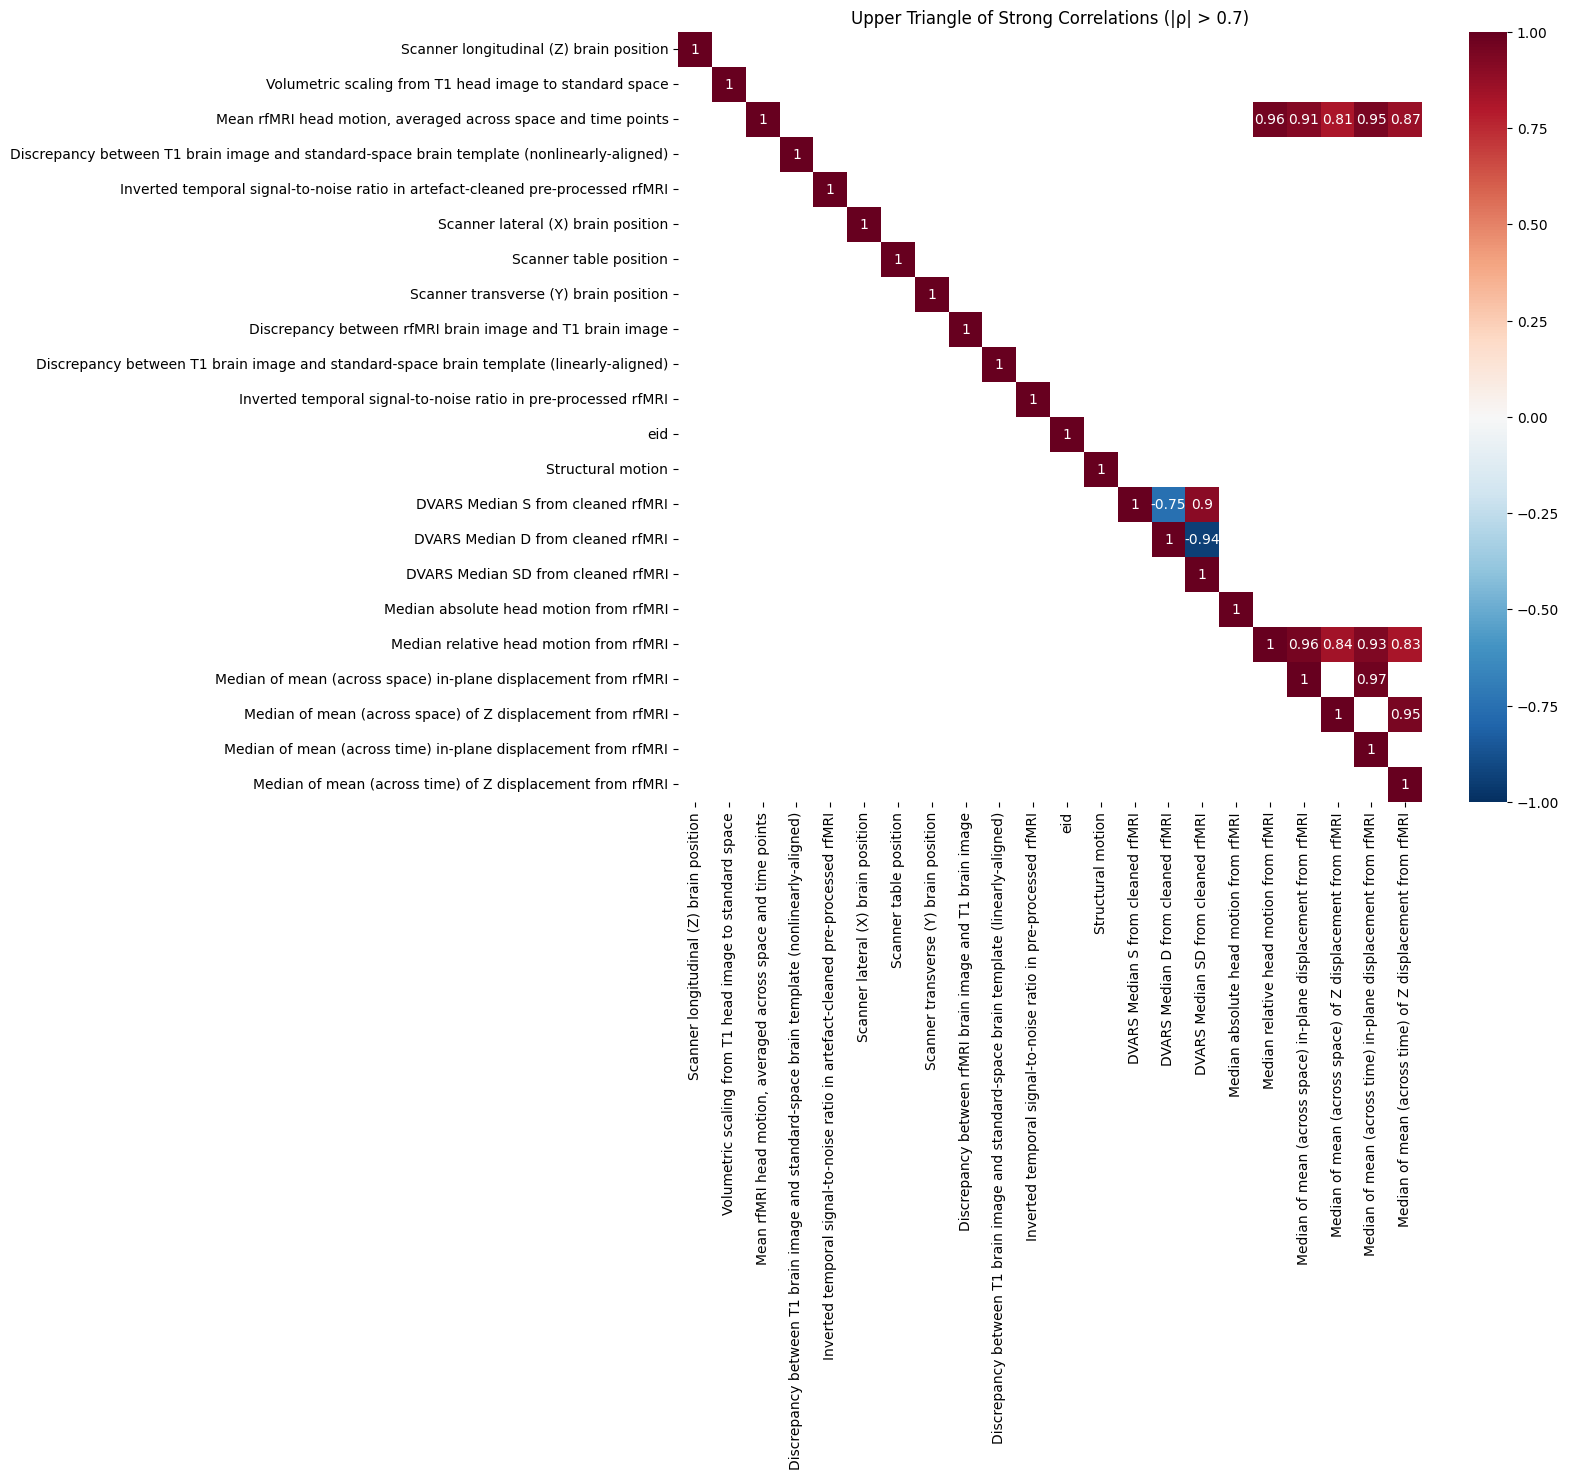

In [ ]:
# Plot corelations among confounds
mask = np.triu(np.ones_like(rho, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(rho.where(mask & (np.abs(rho)>0.7)), 
            annot=True, 
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1)
plt.title("Upper Triangle of Strong Correlations (|ρ| > 0.7)")
plt.show()

In [ ]:
# Display highly correlated confounds
THRESHOLD = 0.8

# Initialize storage
high_corr_pairs = defaultdict(list)
to_drop = set()

# Find all high correlations (excluding diagonal)
for col in rho.columns:
    for idx in rho.index:
        if (col != idx) and (abs(rho.loc[col, idx]) > THRESHOLD):
            high_corr_pairs[col].append((idx, rho.loc[col, idx]))

# Generate dropping recommendations (keeps first occurrence)
recommendations = []
for var, corrs in high_corr_pairs.items():
    if var not in to_drop:  # If not already marked for dropping
        for other_var, corr_val in corrs:
            if other_var not in to_drop:
                recommendations.append(
                    f"Drop '{other_var}' (ρ={corr_val:.2f} with '{var}')")
                to_drop.add(other_var)

# Print human-readable report
print("="*80)
print(f"Highly Correlated Confounds (ρ > {THRESHOLD}):")
print("="*80)
for var, corrs in high_corr_pairs.items():
    if corrs:
        print(f"\n{var} correlates with:")
        for other_var, corr_val in corrs:
            print(f"  → {other_var}: ρ = {corr_val:.2f}")

print("\n" + "="*80)
print("Recommended drops (preserves one from each correlated pair):")
print("="*80)
for rec in sorted(recommendations):
    print(rec)

Highly Correlated Confounds (ρ > 0.8):

Mean rfMRI head motion, averaged across space and time points correlates with:
  → Median relative head motion from rfMRI: ρ = 0.96
  → Median of mean (across space) in-plane displacement from rfMRI: ρ = 0.91
  → Median of mean (across space) of Z displacement from rfMRI: ρ = 0.81
  → Median of mean (across time) in-plane displacement from rfMRI: ρ = 0.95
  → Median of mean (across time) of Z displacement from rfMRI: ρ = 0.87

DVARS Median S from cleaned rfMRI correlates with:
  → DVARS Median SD from cleaned rfMRI: ρ = 0.90

DVARS Median D from cleaned rfMRI correlates with:
  → DVARS Median SD from cleaned rfMRI: ρ = -0.94

DVARS Median SD from cleaned rfMRI correlates with:
  → DVARS Median S from cleaned rfMRI: ρ = 0.90
  → DVARS Median D from cleaned rfMRI: ρ = -0.94

Median relative head motion from rfMRI correlates with:
  → Mean rfMRI head motion, averaged across space and time points: ρ = 0.96
  → Median of mean (across space) in-plane d

In [ ]:
# Drop correlated confounds
rs_confounds = rs_confounds.drop(columns=[
'Median of mean (across space) in-plane displacement from rfMRI',
'Median of mean (across space) of Z displacement from rfMRI',
'Median of mean (across time) in-plane displacement from rfMRI',
'Median of mean (across time) of Z displacement from rfMRI',
])

rho, p = spearmanr(rs_confounds)
p = pd.DataFrame(p, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho = pd.DataFrame(rho, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho_sign = rho.where(rho > 0.7)

# Display highly correlated confounds
THRESHOLD = 0.8

# Initialize storage
high_corr_pairs = defaultdict(list)
to_drop = set()

# Find all high correlations (excluding diagonal)
for col in rho.columns:
    for idx in rho.index:
        if (col != idx) and (abs(rho.loc[col, idx]) > THRESHOLD):
            high_corr_pairs[col].append((idx, rho.loc[col, idx]))

# Generate dropping recommendations (keeps first occurrence)
recommendations = []
for var, corrs in high_corr_pairs.items():
    if var not in to_drop:  # If not already marked for dropping
        for other_var, corr_val in corrs:
            if other_var not in to_drop:
                recommendations.append(
                    f"Drop '{other_var}' (ρ={corr_val:.2f} with '{var}')")
                to_drop.add(other_var)

# Print human-readable report
print("="*80)
print(f"Highly Correlated Confounds (ρ > {THRESHOLD}):")
print("="*80)
for var, corrs in high_corr_pairs.items():
    if corrs:
        print(f"\n{var} correlates with:")
        for other_var, corr_val in corrs:
            print(f"  → {other_var}: ρ = {corr_val:.2f}")

print("\n" + "="*80)
print("Recommended drops (preserves one from each correlated pair):")
print("="*80)
for rec in sorted(recommendations):
    print(rec)

Highly Correlated Confounds (ρ > 0.8):

Mean rfMRI head motion, averaged across space and time points correlates with:
  → Median relative head motion from rfMRI: ρ = 0.96

DVARS Median S from cleaned rfMRI correlates with:
  → DVARS Median SD from cleaned rfMRI: ρ = 0.90

DVARS Median D from cleaned rfMRI correlates with:
  → DVARS Median SD from cleaned rfMRI: ρ = -0.94

DVARS Median SD from cleaned rfMRI correlates with:
  → DVARS Median S from cleaned rfMRI: ρ = 0.90
  → DVARS Median D from cleaned rfMRI: ρ = -0.94

Median relative head motion from rfMRI correlates with:
  → Mean rfMRI head motion, averaged across space and time points: ρ = 0.96

Recommended drops (preserves one from each correlated pair):
Drop 'DVARS Median SD from cleaned rfMRI' (ρ=0.90 with 'DVARS Median S from cleaned rfMRI')
Drop 'Median relative head motion from rfMRI' (ρ=0.96 with 'Mean rfMRI head motion, averaged across space and time points')


In [ ]:
# Verify that no high correlations remain
rs_confounds = rs_confounds.drop(columns=[
'DVARS Median SD from cleaned rfMRI',
'Median relative head motion from rfMRI'
])

rho, p = spearmanr(rs_confounds)
p = pd.DataFrame(p, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho = pd.DataFrame(rho, columns = rs_confounds.columns, index=rs_confounds.columns).T
rho_sign = rho.where(rho > 0.7)

# Display highly correlated confounds
THRESHOLD = 0.8

# Initialize storage
high_corr_pairs = defaultdict(list)
to_drop = set()

# Find all high correlations (excluding diagonal)
for col in rho.columns:
    for idx in rho.index:
        if (col != idx) and (abs(rho.loc[col, idx]) > THRESHOLD):
            high_corr_pairs[col].append((idx, rho.loc[col, idx]))

# Generate dropping recommendations (keeps first occurrence)
recommendations = []
for var, corrs in high_corr_pairs.items():
    if var not in to_drop:  # If not already marked for dropping
        for other_var, corr_val in corrs:
            if other_var not in to_drop:
                recommendations.append(
                    f"Drop '{other_var}' (ρ={corr_val:.2f} with '{var}')")
                to_drop.add(other_var)

# Print human-readable report
print("="*80)
print(f"Highly Correlated Confounds (ρ > {THRESHOLD}):")
print("="*80)
for var, corrs in high_corr_pairs.items():
    if corrs:
        print(f"\n{var} correlates with:")
        for other_var, corr_val in corrs:
            print(f"  → {other_var}: ρ = {corr_val:.2f}")

print("\n" + "="*80)
print("Recommended drops (preserves one from each correlated pair):")
print("="*80)
for rec in sorted(recommendations):
    print(rec)

Highly Correlated Confounds (ρ > 0.8):

Recommended drops (preserves one from each correlated pair):


In [ ]:
# Save confounds
rs_confounds.to_csv(os.path.join(data_path, 'rsMRI/rsmri_conf.csv'), index=False)
# Display confounds
pd.read_csv(os.path.join(data_path, 'rsMRI/rsmri_conf.csv')).columns.to_list()

['Scanner longitudinal (Z) brain position',
 'Volumetric scaling from T1 head image to standard space',
 'Mean rfMRI head motion, averaged across space and time points',
 'Discrepancy between T1 brain image and standard-space brain template (nonlinearly-aligned)',
 'Inverted temporal signal-to-noise ratio in artefact-cleaned pre-processed rfMRI',
 'Scanner lateral (X) brain position',
 'Scanner table position',
 'Scanner transverse (Y) brain position',
 'Discrepancy between rfMRI brain image and T1 brain image',
 'Discrepancy between T1 brain image and standard-space brain template (linearly-aligned)',
 'Inverted temporal signal-to-noise ratio in pre-processed rfMRI',
 'eid',
 'Structural motion',
 'DVARS Median S from cleaned rfMRI',
 'DVARS Median D from cleaned rfMRI',
 'Median absolute head motion from rfMRI']